In [21]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

plt.style.use('default')
sns.set_palette('husl')

In [20]:
RESULTS = Path("../results")

In [11]:
majority_val  = pd.read_csv("../predictions/majority/majority_baseline_val_predictions.csv")
majority_test = pd.read_csv("../predictions/majority/majority_baseline_test_predictions.csv")

tfidf_val  = pd.read_csv("../predictions/logreg/val_predictions.csv")
tfidf_test = pd.read_csv("../predictions/logreg/test_predictions.csv")
print("Loaded:", len(majority_val), len(majority_test), len(tfidf_val), len(tfidf_test))

Loaded: 3718 3718 3718 3718


In [12]:
class_names = ['hate_speech', 'offensive', 'neither']

# Calculating metrics

In [14]:
def calculate_metrics(df, model_name='Model', true_col='label', pred_col='prediction'):
    y_true = df[true_col]
    y_pred = df[pred_col]
    labels = [0, 1, 2]

    accuracy = accuracy_score(y_true, y_pred)

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    _, _, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average='macro', zero_division=0
    )
    _, _, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average='weighted', zero_division=0
    )

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Macro F1': f1_macro,
        'Weighted F1': f1_weighted,
        'Hate Speech Precision': precision[0], 'Hate Speech Recall': recall[0], 'Hate Speech F1': f1[0],
        'Offensive Precision': precision[1], 'Offensive Recall': recall[1], 'Offensive F1': f1[1],
        'Neither Precision': precision[2], 'Neither Recall': recall[2], 'Neither F1': f1[2],
    }

In [28]:
majority_metrics = calculate_metrics(majority_test, 'Majority Baseline', 
                                    true_col='label', pred_col='prediction')
tfidf_metrics = calculate_metrics(tfidf_test, 'TF-IDF + LogReg',
                                 true_col='true_label', pred_col='predicted_label')

metrics_df = pd.DataFrame([majority_metrics, tfidf_metrics])
metrics_df = metrics_df.round(3)

print("Overall metrics:")
print(metrics_df[['Model', 'Accuracy', 'Macro F1', 'Weighted F1']])

Overall metrics:
               Model  Accuracy  Macro F1  Weighted F1
0  Majority Baseline     0.774     0.291        0.676
1    TF-IDF + LogReg     0.895     0.660        0.878


In [22]:
metrics_df.to_csv(RESULTS / "stage1_overall_metrics.csv", index=False)

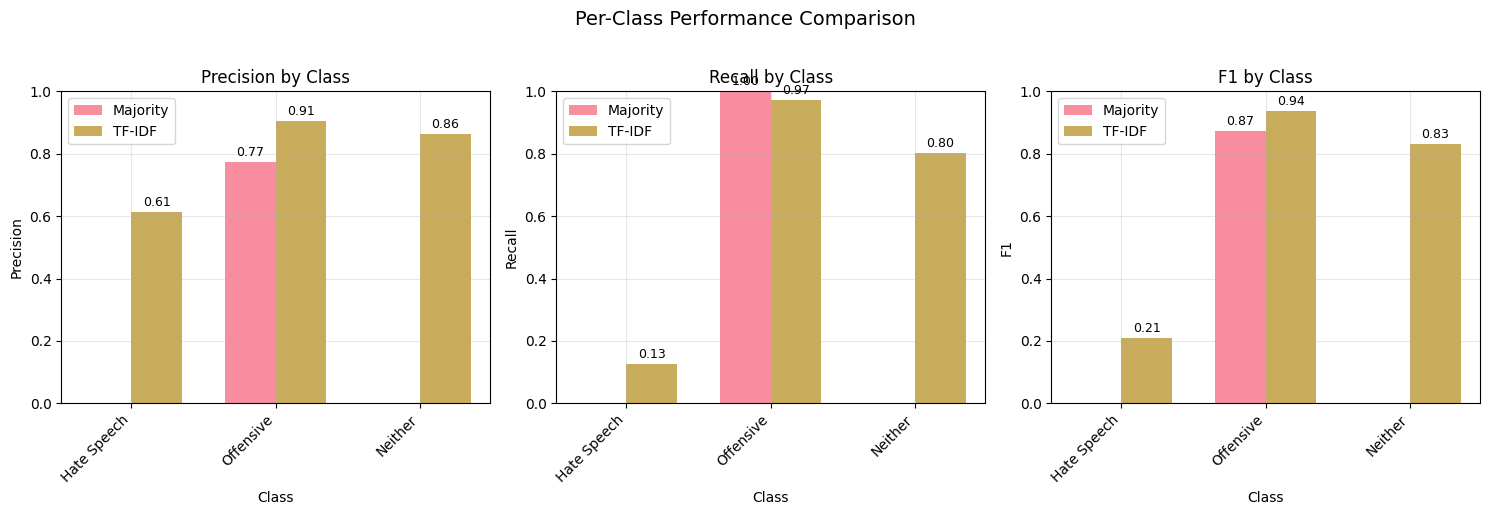

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = ['Precision', 'Recall', 'F1']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    classes = ['Hate Speech', 'Offensive', 'Neither']
    majority_values = [
        majority_metrics[f'{cls} {metric}'] for cls in classes
    ]
    tfidf_values = [
        tfidf_metrics[f'{cls} {metric}'] for cls in classes
    ]
    
    x = np.arange(len(classes))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, majority_values, width, label='Majority', alpha=0.8)
    bars2 = ax.bar(x + width/2, tfidf_values, width, label='TF-IDF', alpha=0.8)
    
    ax.set_xlabel('Class')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} by Class')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Per-Class Performance Comparison', fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig("../results/stage1_per_class_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

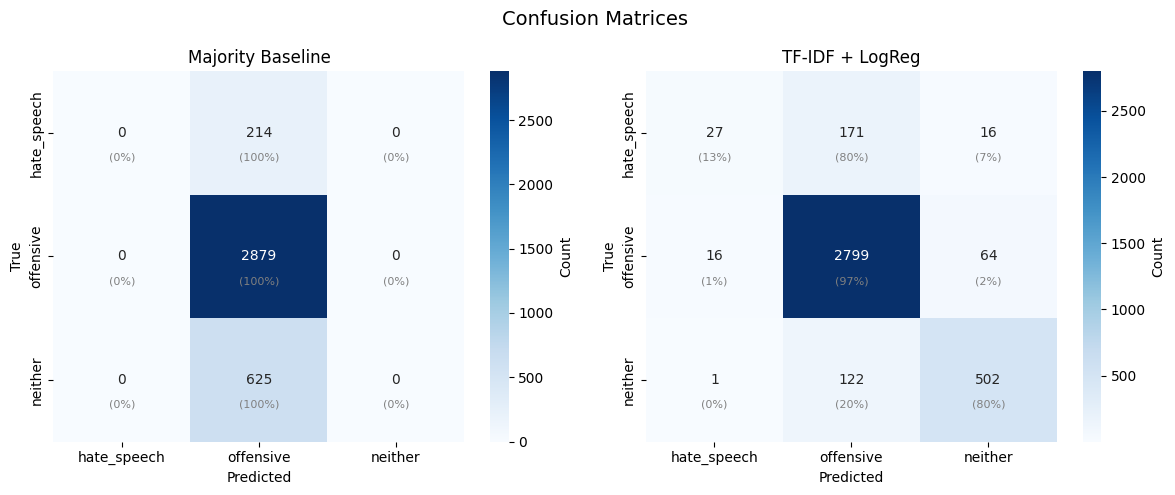

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = [
    (majority_test, 'Majority Baseline', 'label', 'prediction'),
    (tfidf_test, 'TF-IDF + LogReg', 'true_label', 'predicted_label')
]

for idx, (df, title, true_col, pred_col) in enumerate(models):
    cm = confusion_matrix(df[true_col], df[pred_col])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, ax=ax)
    
    for i in range(3):
        for j in range(3):
            percentage = cm_normalized[i, j] * 100
            text = ax.text(j + 0.5, i + 0.7, f'({percentage:.0f}%)',
                          ha='center', va='center', fontsize=8, color='gray')
    
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.suptitle('Confusion Matrices', fontsize=14)
plt.tight_layout()
fig.savefig("../results/stage1_confusion_matrices.png", dpi=200, bbox_inches="tight")
plt.show()